In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In dateset of size 100, 10, each row is an item, each column is a numerical value (price, size, etc).

Using cosine similarity, find 5 the most similar and dissimilar items to index 0.

In [2]:
#create dataset 100, 10:
df = pd.DataFrame(np.random.randint(0, 101, size = (101, 10)),
                  columns = ['price', 'color', 'weight', 'size', 'volume', 'mass', 'density', 'shape', 'tinge', 'discount'])
df

,price,color,weight,size,volume,mass,density,shape,tinge,discount
0,39,41,28,96,41,29,7,99,83,8
1,46,16,65,81,79,81,24,95,67,81
2,17,23,81,31,50,51,5,88,99,70
3,54,69,47,96,93,21,54,9,15,96
4,59,34,53,10,83,75,27,28,24,0
...,...,...,...,...,...,...,...,...,...,...
96,86,92,63,52,78,14,22,58,49,11
97,97,2,19,96,99,81,56,34,54,39
98,23,28,92,86,81,43,1,84,1,58
99,41,1,54,43,95,92,16,2,80,59


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   price     101 non-null    int64
 1   color     101 non-null    int64
 2   weight    101 non-null    int64
 3   size      101 non-null    int64
 4   volume    101 non-null    int64
 5   mass      101 non-null    int64
 6   density   101 non-null    int64
 7   shape     101 non-null    int64
 8   tinge     101 non-null    int64
 9   discount  101 non-null    int64
dtypes: int64(10)
memory usage: 8.0 KB


In [4]:
df.describe()

,price,color,weight,size,volume,mass,density,shape,tinge,discount
count,101.000000,101.000000,101.000000,101.000000,101.000000,101.00000,101.000000,101.000000,101.000000,101.000000
mean,47.267327,49.495050,47.960396,47.792079,48.861386,47.50495,49.029703,50.277228,48.000000,48.267327
std,29.802312,28.127433,27.942770,29.434102,30.282018,26.78941,27.426431,29.296457,30.660724,29.676553
min,0.000000,1.000000,0.000000,0.000000,0.000000,1.00000,1.000000,1.000000,0.000000,0.000000
25%,23.000000,28.000000,25.000000,21.000000,21.000000,21.00000,27.000000,28.000000,22.000000,23.000000
50%,43.000000,43.000000,46.000000,50.000000,51.000000,49.00000,49.000000,51.000000,47.000000,40.000000
75%,70.000000,72.000000,71.000000,75.000000,76.000000,71.00000,71.000000,75.000000,76.000000,73.000000
max,100.000000,99.000000,100.000000,100.000000,100.000000,95.00000,100.000000,99.000000,99.000000,100.000000


Let's see what price correlates with.

In [5]:
corr = df.corrwith(df['price'])
corr.sort_values(ascending = False)

price       1.000000
size        0.220435
mass        0.133837
discount    0.103228
color       0.037526
volume      0.006224
weight     -0.002281
density    -0.011804
shape      -0.069837
tinge      -0.212780
dtype: float64

We see that in our generated dataset:

- positive correlation: high tinge predict higher price.

- negative correlation: higher mass and density predict lower price.

Before calulculating cosine similarity, where -1 is dissimilar and 1 is similar, I need to preprocess the data.

To preprocess the data, I need to use:

- Standardization by StandardScaler if data is normally distributed;
- Normalization by MinMaxScaler if the data is skewed.

In [6]:
#Let's run a test for normal/skewed data:
l = []
for col in df:
    l.append({
        'Column': col,
        'Skewness': df[col].skew(),
        'Kurtosis': df[col].kurtosis()
    })
res = pd.DataFrame(l).set_index('Column').sort_values(by = 'Skewness', ascending = False)
res

,Skewness,Kurtosis
Column,,
price,0.245754,-1.040201
discount,0.232064,-1.236164
tinge,0.068094,-1.319016
color,0.043396,-1.172105
density,0.035392,-1.043486
shape,0.006620,-1.131222
volume,-0.008493,-1.214300
weight,-0.011462,-1.043121
size,-0.019349,-1.244310


Data is normal when Skewness is 0: > 0 is right-tails, < 0 is left-tails.

Kurtosis shows outliers: < 0 light tails, few outliers, > 0 heavy tails, outliers are present.

Size and weight are right-skewed, color, mass, tinge are left-skewed.

Negative Kurtosis shows no outliers.

The data is mostly normal.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

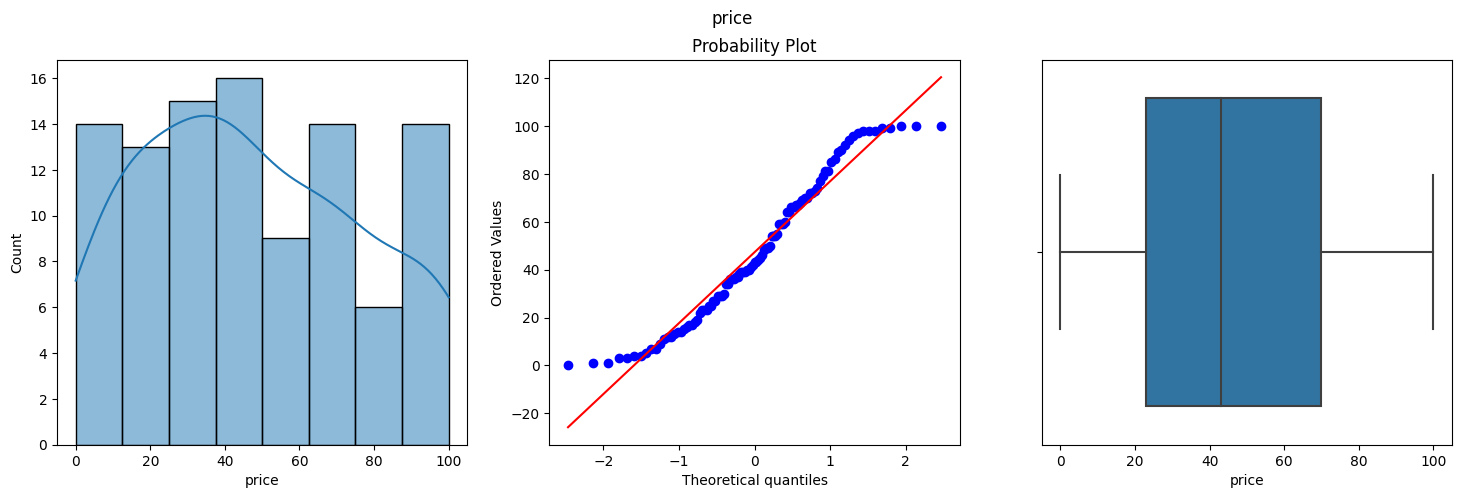

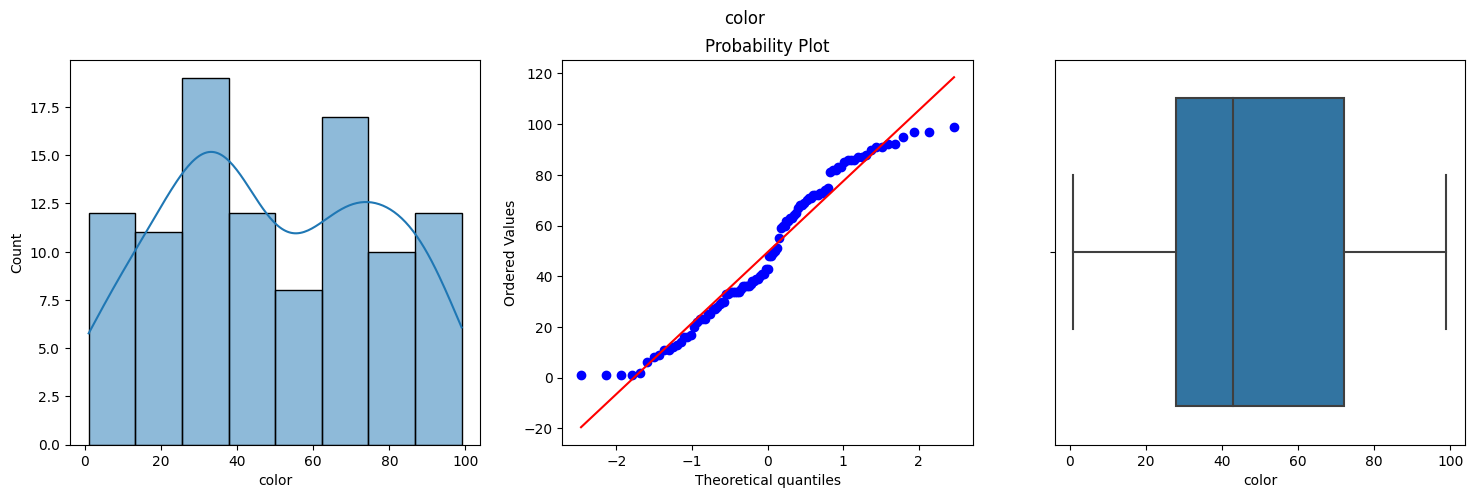

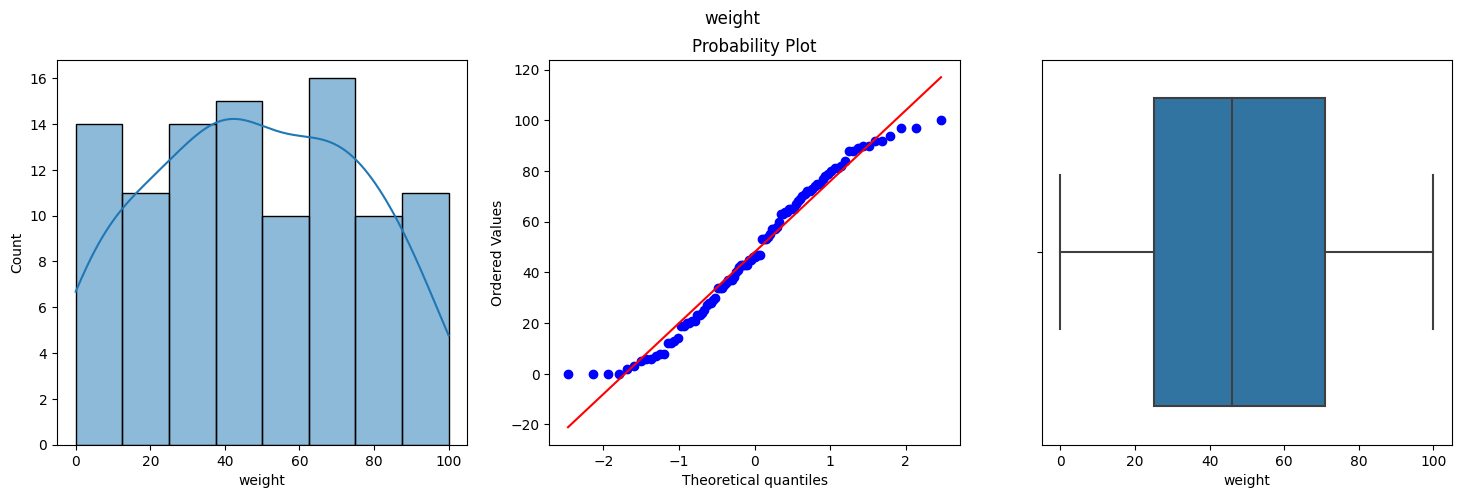

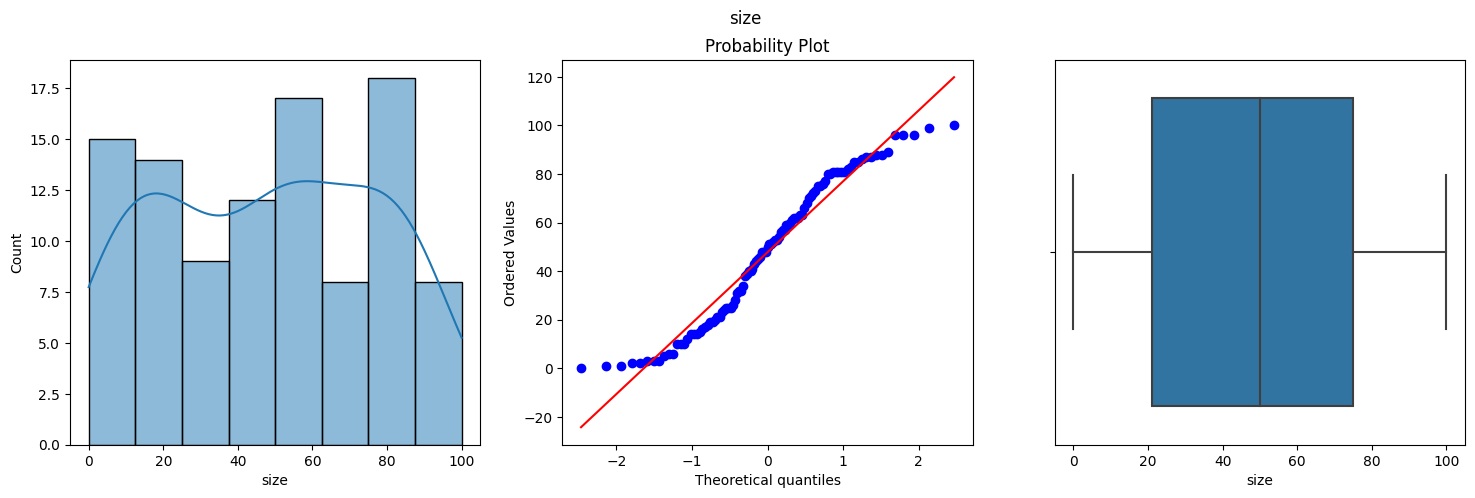

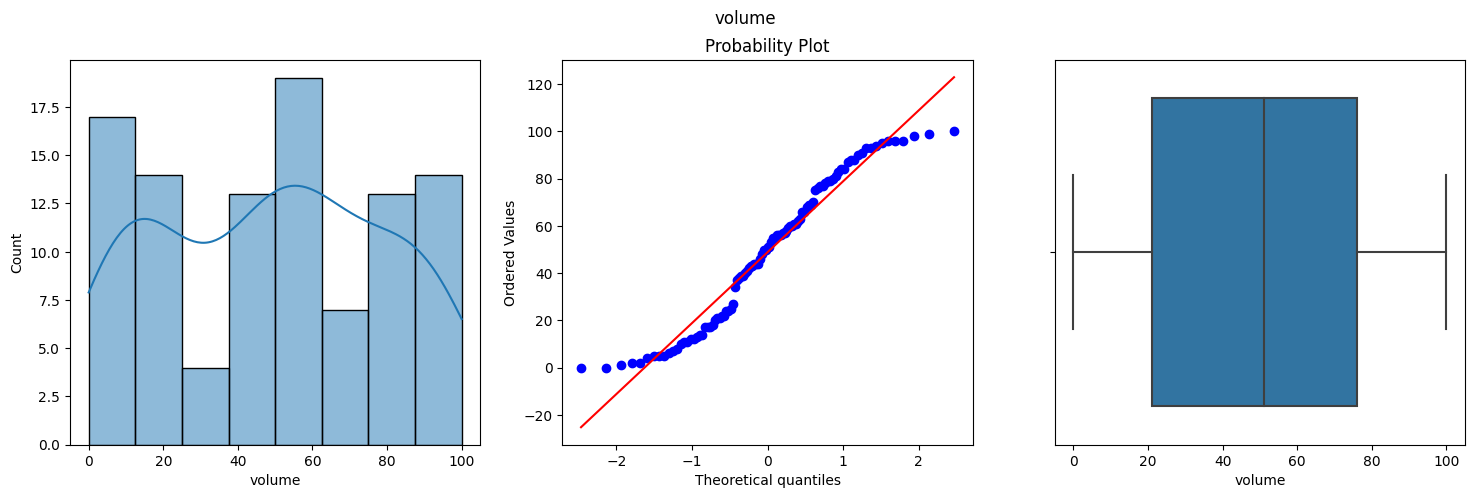

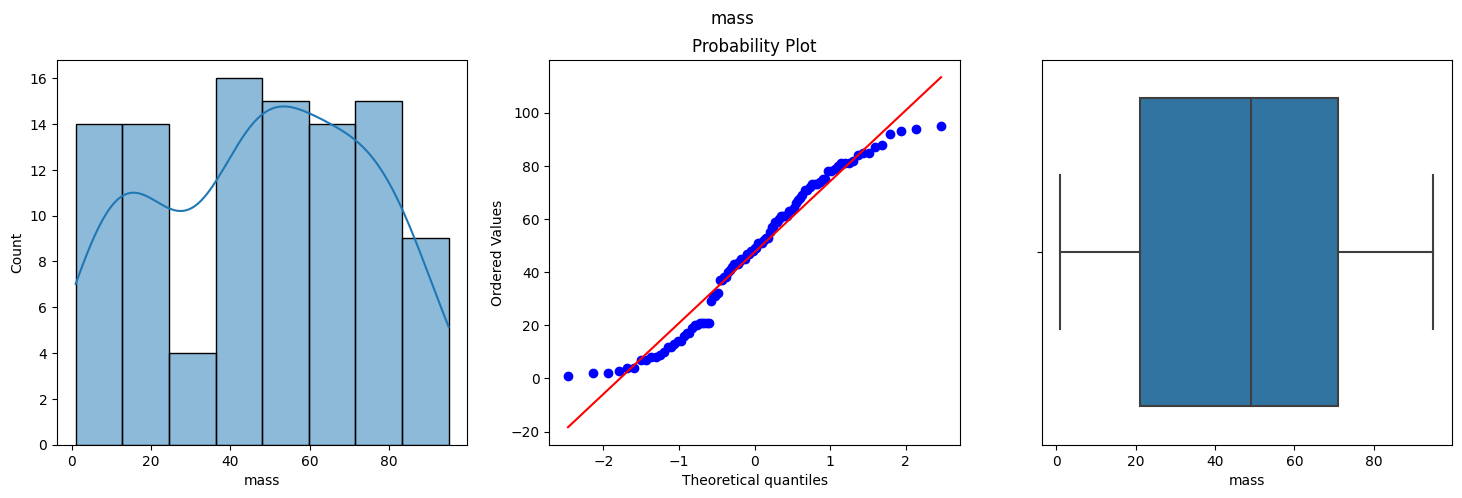

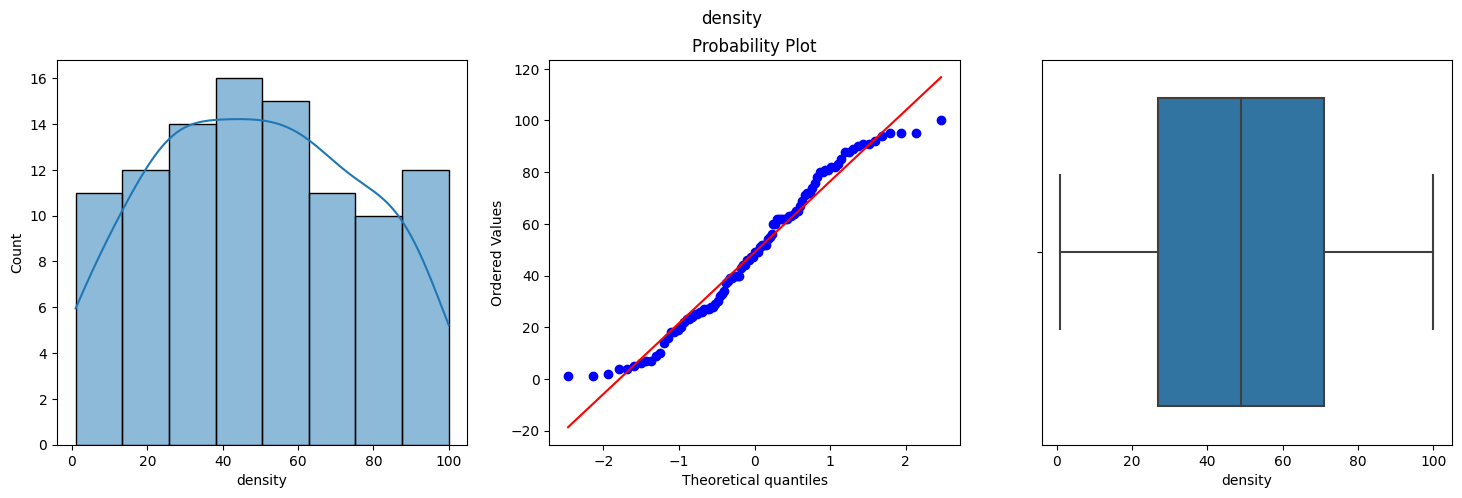

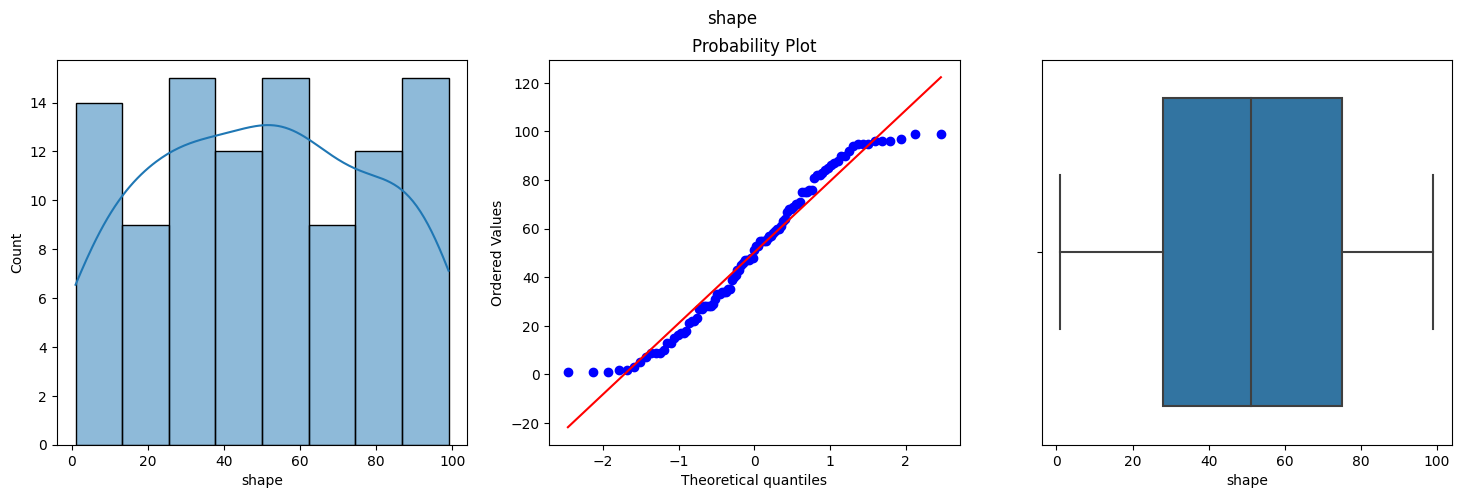

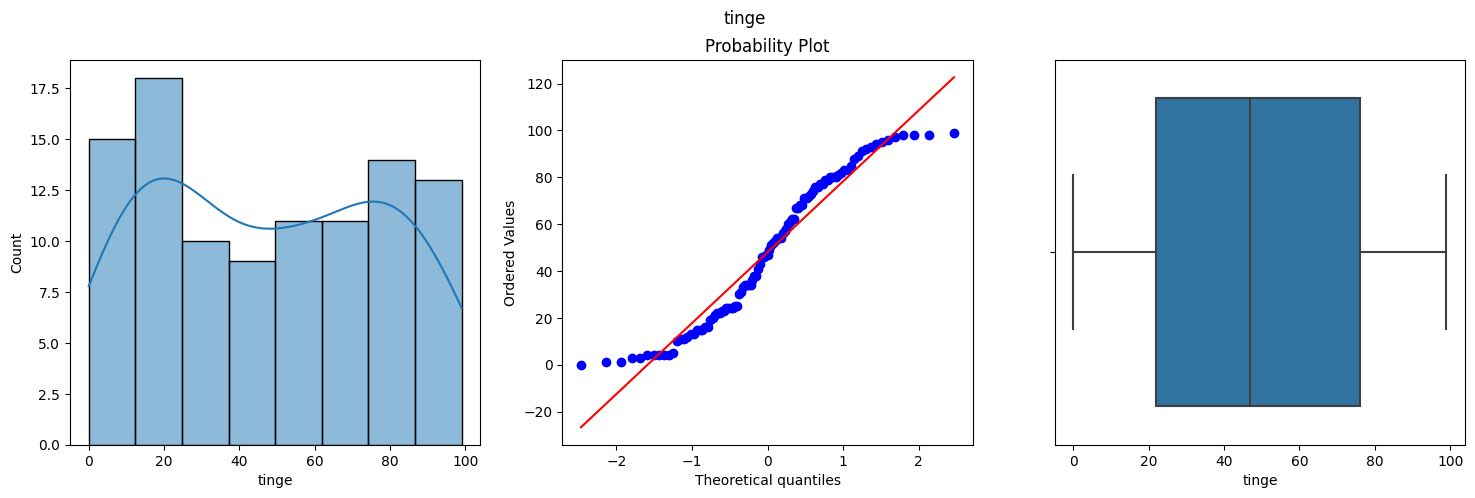

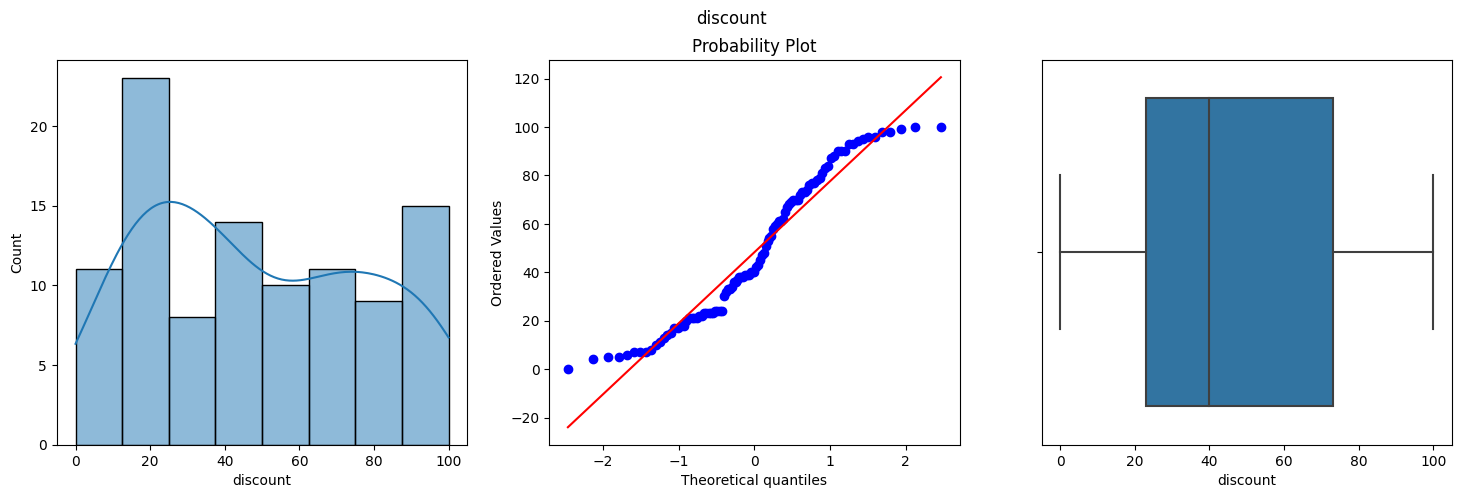

In [7]:
#Let's visualize our data:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

for col in df:
    fig, axes = plt.subplots(1, 3, figsize = (18, 5))
    fig.suptitle(f"{col}")
    sns.histplot(df[col], kde = True, stat = 'count', ax = axes[0])
    stats.probplot(df[col], dist = 'norm', plot = axes[1])
    sns.boxplot(x = df[col], ax = axes[2])

We see that outliers are not detected and that data is mostly normal.

Normal data allows us to apply StandardScaler to preprocess our data before calculating cosine similarity.

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)
cos_sim = cosine_similarity(scaled_df)

In [9]:
ind_0 = cos_sim[0]
similar = np.argsort(ind_0)[::-1][1:6]
similar

array([12, 25, 84, 75, 24])

In [10]:
dissimilar = np.argsort(ind_0)[:5]
dissimilar

array([56, 94, 31, 80, 21])

In [11]:
print('Index 0:')
print(df.iloc[[0]])
print('\n5 Similar items:')
print(df.iloc[similar])
print('\n5 Dissimilar items:')
print(df.iloc[dissimilar])

Index 0:
   price  color  weight  size  volume  mass  density  shape  tinge  discount
0     39     41      28    96      41    29        7     99     83         8

5 Similar items:
    price  color  weight  size  volume  mass  density  shape  tinge  discount
12      3     48       0    85      17    10       43     85     80         5
25     70     30      43    99      56    17       25     67     98        60
84     40     39      42    28      53    42       27     76     92        23
75     59     72      12    53       8    19       26     57     76        37
24     44     38      45    48      18    45       72     81     95         5

5 Dissimilar items:
    price  color  weight  size  volume  mass  density  shape  tinge  discount
56     66     82      72    16      62    52       62      1      3        94
94     37     71      84    12      44    72       67     22     46        48
31     49     72      64    32      55    20       92     21     38        78
80     64     50  